初始化spark环境

In [1]:
import findspark
findspark.init()

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession # SparkSession 是Spark 2.0版本的新入口
spark = SparkSession.builder.master('local').getOrCreate()

# 加载 utils.py 中的自定义方法
from utils import *

# 特征工程

设置schema

In [2]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

schema = StructType([
StructField("duration",IntegerType(),False),
StructField("protocol_type",StringType(),False),
StructField("service",StringType(),False),
StructField("flag",StringType(),False),
StructField("src_bytes",IntegerType(),False),
StructField("dst_bytes",IntegerType(),False),
StructField("land",IntegerType(),False),
StructField("wrong_fragment",IntegerType(),False),
StructField("urgent",IntegerType(),False),
StructField("hot",IntegerType(),False),
StructField("num_failed_logins",IntegerType(),False),
StructField("logged_in",IntegerType(),False),
StructField("num_compromised",IntegerType(),False),
StructField("root_shell",IntegerType(),False),
StructField("su_attempted",IntegerType(),False),
StructField("num_root",IntegerType(),False),
StructField("num_file_creations",IntegerType(),False),
StructField("num_shells",IntegerType(),False),
StructField("num_access_files",IntegerType(),False),
StructField("num_outbound_cmds",IntegerType(),False),
StructField("is_host_login",IntegerType(),False),
StructField("is_guest_login",IntegerType(),False),
StructField("count",IntegerType(),False),
StructField("srv_count",IntegerType(),False),
StructField("serror_rate",FloatType(),False),
StructField("srv_serror_rate",FloatType(),False),
StructField("rerror_rate",FloatType(),False),
StructField("srv_rerror_rate",FloatType(),False),
StructField("same_srv_rate",FloatType(),False),
StructField("diff_srv_rate",FloatType(),False),
StructField("srv_diff_host_rate",FloatType(),False),
StructField("dst_host_count",IntegerType(),False),
StructField("dst_host_srv_count",IntegerType(),False),
StructField("dst_host_same_srv_rate",FloatType(),False),
StructField("dst_host_diff_srv_rate",FloatType(),False),
StructField("dst_host_same_src_port_rate",FloatType(),False),
StructField("dst_host_srv_diff_host_rate",FloatType(),False),
StructField("dst_host_serror_rate",FloatType(),False),
StructField("dst_host_srv_serror_rate",FloatType(),False),
StructField("dst_host_rerror_rate",FloatType(),False),
StructField("dst_host_srv_rerror_rate",FloatType(),False),
StructField("label",StringType(),False)
])

从本地读取数据

In [3]:
# 从csv中读取
dataset = spark.read.csv('Data/kddcup.data.gz', header=None,schema=schema)
dataset.printSchema()

root
 |-- duration: integer (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: integer (nullable = true)
 |-- dst_bytes: integer (nullable = true)
 |-- land: integer (nullable = true)
 |-- wrong_fragment: integer (nullable = true)
 |-- urgent: integer (nullable = true)
 |-- hot: integer (nullable = true)
 |-- num_failed_logins: integer (nullable = true)
 |-- logged_in: integer (nullable = true)
 |-- num_compromised: integer (nullable = true)
 |-- root_shell: integer (nullable = true)
 |-- su_attempted: integer (nullable = true)
 |-- num_root: integer (nullable = true)
 |-- num_file_creations: integer (nullable = true)
 |-- num_shells: integer (nullable = true)
 |-- num_access_files: integer (nullable = true)
 |-- num_outbound_cmds: integer (nullable = true)
 |-- is_host_login: integer (nullable = true)
 |-- is_guest_login: integer (nullable = true)
 |-- count: integer (nullable = true

合并稀疏特征

In [4]:
import pyspark.sql.functions as F
from utils import mapper_mergeSparseFeatureInService
from utils import mapper_attack2majorindex
udf_mapper_attack2majorindex = F.UserDefinedFunction(mapper_attack2majorindex,IntegerType())
udf_mergeSparseFeatureInService = F.UserDefinedFunction(mapper_mergeSparseFeatureInService,StringType())

In [5]:
dataset = dataset.select(
    *[udf_mergeSparseFeatureInService(column).alias('service') if column == 'service' else column for column in dataset.columns]
)

划分攻击类型

In [6]:
dataset = dataset.select(
    *[udf_mapper_attack2majorindex(column).alias('label') if column == 'label' else column for column in dataset.columns]
)

分类编码 Pipeline 

In [12]:
from pyspark.ml.feature import StringIndexer

fearture_string = ['protocol_type', 'service', 'flag']
pipeline_stringindex = Pipeline(stages=[
    StringIndexer(inputCol=c, outputCol='{}_index'.format(c),handleInvalid='keep')
    for c in fearture_string
])

pipeline_stringindex_fitted = pipeline_stringindex.fit(dataset=dataset)

+-------------+-------------------+-------+-------------+----+----------+-----+
|protocol_type|protocol_type_index|service|service_index|flag|flag_index|label|
+-------------+-------------------+-------+-------------+----+----------+-----+
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
+-------------+-------------------+-------+-------------+----+----------+-----+
only showing top 5 rows



In [7]:
# 加载 pipeline
from pyspark.ml import PipelineModel
pipeline_stringindex_fitted = PipelineModel.load('SparkRFonAll/pipeline_stringindex_fitted')

In [8]:
dataset_indexed = pipeline_stringindex_fitted.transform(dataset=dataset)
dataset_indexed.select('protocol_type','protocol_type_index','service','service_index','flag','flag_index','label').show(5)

+-------------+-------------------+-------+-------------+----+----------+-----+
|protocol_type|protocol_type_index|service|service_index|flag|flag_index|label|
+-------------+-------------------+-------+-------------+----+----------+-----+
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
|          tcp|                1.0|   http|          2.0|  SF|       0.0|    0|
+-------------+-------------------+-------+-------------+----+----------+-----+
only showing top 5 rows



In [43]:
# 存储 pipeline
pipeline_stringindex_fitted.save('SparkRFonAll/pipeline_stringindex_fitted')

# 随机森林

In [9]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from time import time

构造训练集 [features][label]

In [10]:
def featuresToVec(dataset_indexed):
    # 构造特征向量
    features=[dataset_indexed.columns[0]]+dataset_indexed.columns[4:]
    features.remove('label')
    feature_vec = VectorAssembler(inputCols=features,outputCol='feature_vec').transform(dataset_indexed)
    # 组合数据集： 特征向量，标签
    return feature_vec.select('feature_vec','label')

In [11]:
dataset_indexed = featuresToVec(dataset_indexed)
# 划分训练集，测试集
train_set,test_set = dataset_indexed.randomSplit([0.9,0.1])

In [16]:
rf = RandomForestClassifier(
    featuresCol='feature_vec', # 特征
    labelCol='label', #标签
    impurity='gini', # 考虑到样本分布和计算效率
    maxDepth=8, # 最大深度
    maxBins=72, # 根据样本训练集确定
    numTrees=200, # 树个数
    subsamplingRate = 0.5, # 默认值为1，用于训练每棵树的数据占总训练集比例，可用于加速
    seed=5, 
)

In [17]:
# 训练模型
t0 = time()
rf_model = rf.fit(train_set)
tt = time() -t0
print("Trains in {} seconds".format(round(tt,3)))

Trains in 4353.546 seconds


In [18]:
# 保存训练好的机器学习模型
rf_model.save('SparkRFonAll/rf_SparkRF')

In [12]:
# 加载本地机器学习模型
from pyspark.ml.classification import RandomForestClassificationModel
rf_model= RandomForestClassificationModel.load('SparkRFonAll/rf_SparkRF')

In [13]:
# 预测
t0 = time()
test_result = rf_model.transform(test_set)
tt = time() -t0
print("Perdict in {} seconds".format(round(tt,3)))

Perdict in 0.127 seconds


# 评价

#### 交叉验证打分

In [74]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction')
score={}
# for metric in ['accuracy','f1','weightedPrecision','weightedRecall']:
for metric in ['accuracy','f1']:
    t0 = time()
    score[metric] = evaluator.evaluate(dataset=test_result,params={evaluator.metricName:metric})
    tt = time() -t0
    print("%-*s %f \t %f seconds"%( 30 , metric, score[metric], round(tt,3)))
    

accuracy                       0.999515 	 69.876000
f1                             0.999506 	 99.630000


#### 验证集打分

数据导入与处理

In [14]:
corrected = spark.read.csv('Data/corrected.gz', header=None,schema=schema)

# 合并稀疏特征
corrected = corrected.select(
    *[udf_mergeSparseFeatureInService(column).alias('service') if column == 'service' else column for column in corrected.columns]
)
# 攻击类型分类
corrected = corrected.select(
    *[udf_mapper_attack2majorindex(column).alias('label') if column == 'label' else column for column in corrected.columns]
)
# 分类编码
corrected_indexed = pipeline_stringindex_fitted.transform(corrected)

# 划分 features vector 和 label
corrected_set = featuresToVec(corrected_indexed)

预测

In [15]:
t0 = time()
corrected_result = rf_model.transform(corrected_set)
tt = time() -t0
print("Perdict in {} seconds".format(round(tt,3)))

Perdict in 0.034 seconds


评价

In [79]:
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction')
score={}
# for metric in ['accuracy','weightedPrecision','weightedRecall','f1']:
for metric in ['accuracy','f1']:
    t0 = time()
    score[metric] = evaluator.evaluate(dataset=corrected_result,params={evaluator.metricName:metric})
    tt = time() -t0
    print("%-*s %f \t %f seconds"%( 30 , metric, score[metric], round(tt,3)))

accuracy                       0.923210 	 131.599000 seconds
f1                             0.903593 	 176.263000 seconds


# 混淆矩阵

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [17]:
# convert DF column to list
def getListFromDF(df,colname):
    tmp = df.select(colname).toPandas()
    return tmp.iloc[:,0].values

In [18]:
# 直接根据测试结果DF 绘制混淆矩阵,并输出评分
def drawFromDF(dataset):
    true = getListFromDF(dataset,'label')
    pred = getListFromDF(dataset,'prediction')
    cm,plt = drawConfusionMatrix(true,pred,[0,1,2,3,4])
    plt.show()
    preAndRec(cm=cm,labels=[0,1,2,3,4])
    return cm,true,pred

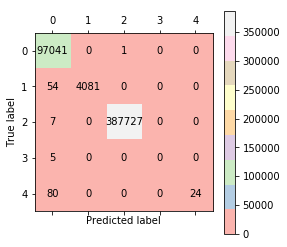

------------------------------
Precision:
0 : 	 0.998498
1 : 	 1.000000
2 : 	 0.999997
3 : 	 nan
4 : 	 1.000000

Recall:
0 : 	 0.999990
1 : 	 0.986941
2 : 	 0.999982
3 : 	 0.000000
4 : 	 0.230769
------------------------------


C:\Users\asus\Desktop\lab\utils.py:174: RuntimeWarning: invalid value encountered in longlong_scalars
  result[x]= tp/s if s is not 0 else 0


In [22]:
test_cm,test_true,test_pred = drawFromDF(dataset=test_result)

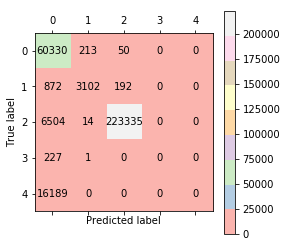

------------------------------
Precision:
0 : 	 0.717173
1 : 	 0.931532
2 : 	 0.998918
3 : 	 nan
4 : 	 nan

Recall:
0 : 	 0.995660
1 : 	 0.744599
2 : 	 0.971643
3 : 	 0.000000
4 : 	 0.000000
------------------------------


C:\Users\asus\Desktop\lab\utils.py:174: RuntimeWarning: invalid value encountered in longlong_scalars
  result[x]= tp/s if s is not 0 else 0


In [21]:
corrected_cm,corrected_true,corrected_pred = drawFromDF(dataset=corrected_result)

In [23]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction')
score_correct={}
# for metric in ['accuracy','f1','weightedPrecision','weightedRecall']:
for metric in ['accuracy','f1']:
    t0 = time()
    score_correct[metric] = evaluator.evaluate(dataset=corrected_result,params={evaluator.metricName:metric})
    tt = time() -t0
    print("%-*s %f \t %f seconds"%( 30 , metric, score_correct[metric], round(tt,3)))

accuracy                       0.921994 	 178.036000 seconds
f1                             0.901508 	 200.231000 seconds
